# Imports

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException 

import re

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import WordNetLemmatizer

import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence


# Scraping

In [ ]:
driver = webdriver.Chrome()
driver.implicitly_wait(20) 
driver.get("https://myanimelist.net/topanime.php?limit=50")
driver.maximize_window()

f = open("reviews.csv", "a", encoding="utf-8")
#f.write("id;name;score;demographic;genres;themes;username;rating;review\n")

animeListing_container = driver.find_element(By.XPATH, "/html/body/div[1]/div[2]/div[3]/div[2]/div[4]")
animeListing_elements = driver.find_elements(By.CLASS_NAME, "anime_ranking_h3")

id = 0 #changeable - zadnji id u reviews
i = 0
for i in range(len(animeListing_elements) - 0): #changeable - zadnji zapisan anime
    animeListing_container = driver.find_element(By.XPATH, "/html/body/div[1]/div[2]/div[3]/div[2]/div[4]")
    animeListing_elements = driver.find_elements(By.CLASS_NAME, "anime_ranking_h3")
    #del animeListing_elements[0:36] #changeable - zadnji zapisan anime
    
    animeListing_elements[i].click()
    name = driver.find_element(By.XPATH, "/html/body/div[1]/div[2]/div[3]/div[1]/div/div[1]/div/h1/strong").text
    name = re.sub(r";", ",", name)
    score = driver.find_element(By.XPATH, "/html/body/div[1]/div[2]/div[3]/div[2]/table/tbody/tr/td[2]/div[1]/table/tbody/tr[1]/td/div[1]/div[1]/div[1]/div[1]/div[1]/div").text
    
    try:
        genre_div = driver.find_element(By.XPATH, "//*[contains(text(), 'Genres:')]//ancestor::div[@class='spaceit_pad']")
        genre_elements = genre_div.find_elements(By.TAG_NAME, 'a')
        genres = [genre.text for genre in genre_elements]
    except NoSuchElementException:
        genres = []
    
    try:
        theme_div = driver.find_element(By.XPATH, "//*[contains(text(), 'Themes:')]//ancestor::div[@class='spaceit_pad']")
        theme_elements = theme_div.find_elements(By.TAG_NAME, 'a')
        themes = [theme.text for theme in theme_elements]
    except NoSuchElementException:
        themes = []
    
    try:
        demographic_div = driver.find_element(By.XPATH, "//*[contains(text(), 'Demographic:')]//ancestor::div[@class='spaceit_pad']")
        demographic_element = demographic_div.find_element(By.TAG_NAME, 'a')
        demographic = demographic_element.text
    except NoSuchElementException:
        demographic = ""
    
    driver.find_element(By.LINK_TEXT, 'Reviews').click()
    driver.find_element(By.XPATH, "/html/body/div[1]/div[2]/div[3]/div[2]/table/tbody/tr/td[2]/div[1]/div[5]/div[2]/span[4]").click()
    driver.find_element(By.CLASS_NAME, 'btn-show-filter').click()
    driver.find_element(By.XPATH, "//li[@data-id='3']").click()
    driver.find_element(By.CLASS_NAME, 'btn-show-filter').click()
    readMore_elements = driver.find_elements(By.CLASS_NAME, "js-readmore")
    for element in readMore_elements:
        element.click()
    review_elements = driver.find_elements(By.CLASS_NAME ,"review-element")
    for element in review_elements:
        username = element.find_element(By.CLASS_NAME, "username").text
        #print(username)
        review = element.find_element(By.CLASS_NAME, "text").text
        review = re.sub(r"\s+", " ", review)
        review = re.sub(r";", ",", review)
        #print(review)
        rating = element.find_element(By.CLASS_NAME, "rating").text[19:]
        if int(rating) > 5:
            continue
        #print(rating[19:])
        id += 1
        f.write(str(id) + ";" + name + ";" + score + ";" + demographic + ";" + str(genres) + ";" + str(themes) + ";" + username + ";" + rating + ";" + review + "\n")
        print(str(id) + " | " + name + " | " + score + " | " + demographic + " | " + str(genres) + " | " + str(themes) + " | " + username + " | " + rating + " | " + "REVIEW_TEXT")
        
    driver.get("https://myanimelist.net/topanime.php?limit=50")
    i += 1

f.close()
driver.quit()


In [2]:
df = pd.read_csv(r"reviews.csv", sep=';')
df.head()

,id,name,score,demographic,genres,themes,username,rating,review
0,0,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],Czekaj,10,"With lives so short, why do we even bother? To..."
1,1,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],chekkit,10,I feel so catered to. It feels like an eternit...
2,2,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],Trikkiez,4,Style- Frieren doesn't have its own unique sty...
3,3,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],ShabbaRico,5,"TL,DR: 5/10, I don't recommend this for anyone..."
4,4,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],TheRealist68,9,"Through 3 episodes, Frieren appears to be a un..."


# User Sentiment

In [4]:
def preprocess(text):
    text = re.sub(r"[^a-zA-Z\.\?!]", " ", text)
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [token for token in tokens if token not in stopwords.words("english")] #potencijanlo bespotrebno
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = " ".join(lemmatized_tokens)
    return processed_text

def get_sentiment(rating):
    if 1 <= rating <= 5:
        return "0"
    else:
        return "1"

In [5]:
tqdm.pandas()
df["review"] = df["review"].progress_apply(preprocess)
df["sentiment"] = df["rating"].progress_apply(get_sentiment)
df.head()

100%|██████████████████████████████████████████████████████████████████████████| 1738/1738 [00:00<00:00, 505702.42it/s]


,id,name,score,demographic,genres,themes,username,rating,review,sentiment
0,0,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],Czekaj,10,life short even bother ? someone life thousand...,1
1,1,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],chekkit,10,feel catered . feel like eternity since given ...,1
2,2,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],Trikkiez,4,style frieren unique style way . feel like eve...,0
3,3,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],ShabbaRico,5,tl dr recommend anyone standard enjoys fantasy...,0
4,4,Sousou no Frieren,9.32,Shounen,"['Adventure', 'Drama', 'Fantasy']",[],TheRealist68,9,episode frieren appears unique masterpiece sto...,1


In [11]:
# used for balancing out pos. and neg. reviews
# WARNING: DO NOT RUN THIS MAHINALNO. OBRISAT CES DZABA ROWS A VEC JE ISBALANSIRANO
removed_count = 0
for index, row in df.iterrows():
    if row['sentiment'] == "0":
        df = df.drop(index)  
        removed_count += 1
        if removed_count == 210: 
            break


sentiment
1    762
0    762
Name: count, dtype: int64

In [42]:
df.to_csv("preprocessed_reviews.csv", sep=";", index=False)

# Graphs

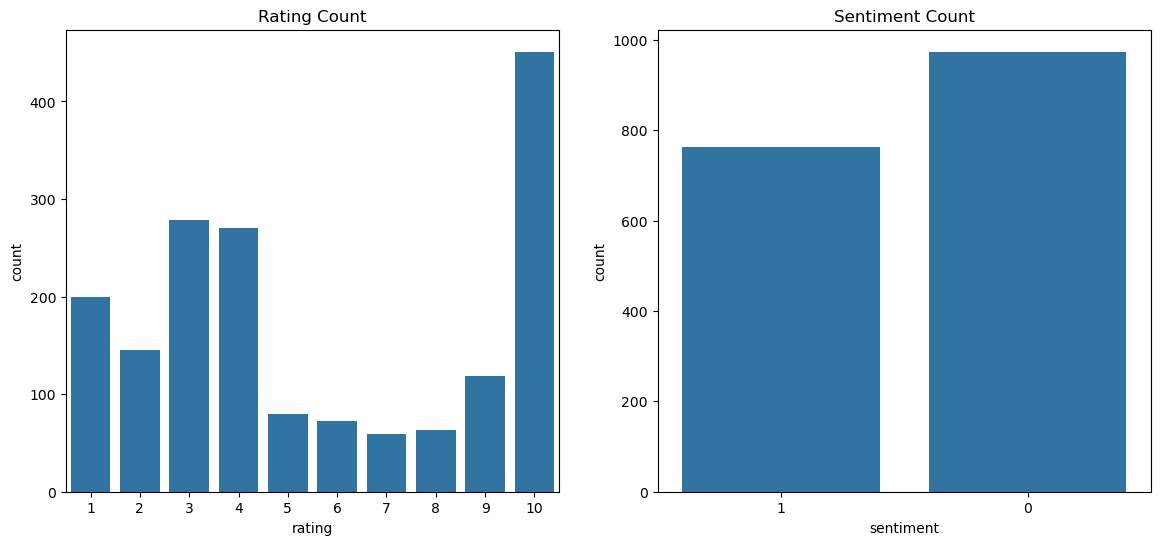

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x='rating', data=df, ax=axes[0])
axes[0].set_title("Rating Count")

sns.countplot(x='sentiment', data=df, ax=axes[1])
axes[1].set_title("Sentiment Count")

plt.show()


100%|███████████████████████████████████████████████████████████████████████████████| 974/974 [00:02<00:00, 344.65it/s]


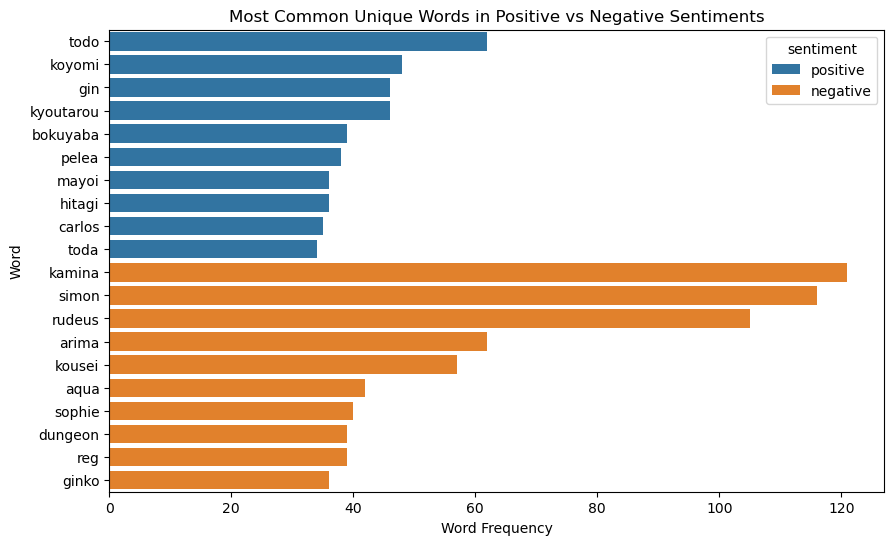

In [41]:
positive_df = df[df['sentiment'] == "1"]
negative_df = df[df['sentiment'] == "0"]

positive_tokens = positive_df['review'].progress_apply(nltk.word_tokenize).explode()
negative_tokens = negative_df['review'].progress_apply(nltk.word_tokenize).explode()

common_tokens = set(positive_tokens) & set(negative_tokens)

# izbrise zajednice tokene
positive_tokens_unique = positive_tokens[~positive_tokens.isin(common_tokens)]
negative_tokens_unique = negative_tokens[~negative_tokens.isin(common_tokens)]

positive_freq_dist_unique = nltk.FreqDist(positive_tokens_unique)
negative_freq_dist_unique = nltk.FreqDist(negative_tokens_unique)

positive_common_words = positive_freq_dist_unique.most_common(10)
negative_common_words = negative_freq_dist_unique.most_common(10)

positive_df_plot = pd.DataFrame(positive_common_words, columns=['word', 'count'])
positive_df_plot['sentiment'] = 'positive'

negative_df_plot = pd.DataFrame(negative_common_words, columns=['word', 'count'])
negative_df_plot['sentiment'] = 'negative'

plot_df = pd.concat([positive_df_plot, negative_df_plot])

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', hue='sentiment', data=plot_df)

plt.title('Most Common Unique Words in Positive vs Negative Sentiments')
plt.xlabel('Word Frequency')
plt.ylabel('Word')

plt.show()

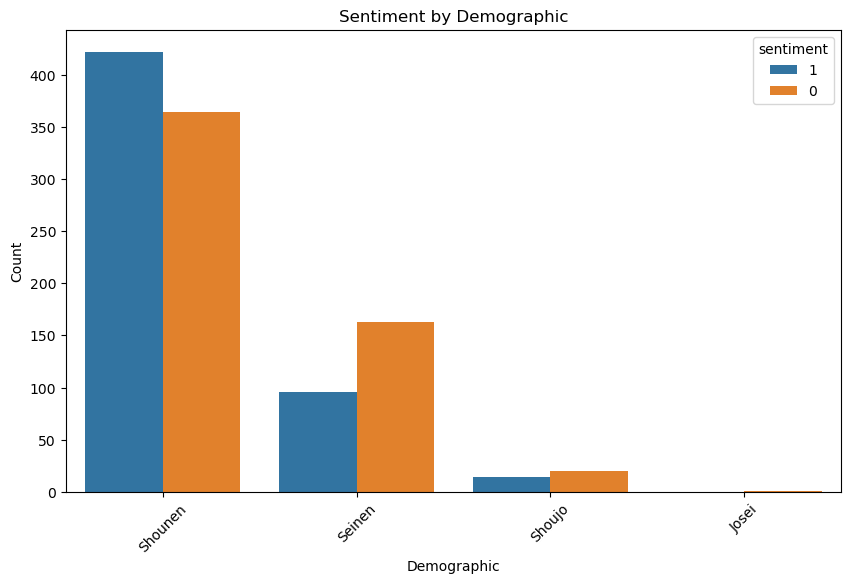

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(x='demographic', hue='sentiment', data=df)
plt.title('Sentiment by Demographic')
plt.xlabel('Demographic')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Training Our Comparison

In [10]:
X = df["review"].values
Y = df["sentiment"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 2)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

model = LogisticRegression(max_iter = 1000)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [11]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print("Accuracy score on the training data: ", training_data_accuracy)

X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)
print("Accuracy score on the test data: ", test_data_accuracy)

Accuracy score on the training data:  0.9572368421052632
Accuracy score on the test data:  0.8831417624521073


# Vader Comparison

In [12]:
vader = SentimentIntensityAnalyzer()

def get_vader_sentiment(review):
    score = vader.polarity_scores(review)
    if score['compound'] >= 0.0:
        return '1'
    else:
        return '0'

vader_predictions = [get_vader_sentiment(review) for review in df["review"][int(df.shape[0] * 0.7):]] #X_test

vader_accuracy = accuracy_score(Y_test, vader_predictions)
print("Accuracy score using our model on the test data: ", test_data_accuracy)
print("Accuracy score using VADER model on the test data: ", vader_accuracy)

Accuracy score using our model on the test data:  0.8831417624521073
Accuracy score using VADER model on the test data:  0.5191570881226054


# TextBlob Comparison

In [13]:
def get_textblob_sentiment(review):
    sentiment = TextBlob(review).sentiment.polarity
    if sentiment >= 0.0:
        return "1"
    else:
        return "0"

textblob_predictions = [get_textblob_sentiment(review) for review in df["review"][int(df.shape[0] * 0.7):]]

textblob_accuracy = accuracy_score(Y_test, textblob_predictions)
print("Accuracy score using our model on the test data: ", test_data_accuracy)
print("Accuracy score using TextBlob on the test data: ", textblob_accuracy)

Accuracy score using our model on the test data:  0.8831417624521073
Accuracy score using TextBlob on the test data:  0.49616858237547895


# Flair Comparison

In [14]:
flair_model = TextClassifier.load('sentiment')

def get_flair_sentiment(review):
    sentence = Sentence(review)
    flair_model.predict(sentence)
    sentiment = sentence.labels[0].value
    if sentiment == "POSITIVE":
        return "1"
    else:
        return "0"
        
flair_predictions = [get_flair_sentiment(review) for review in df["review"][int(df.shape[0] * 0.7):]]

flair_accuracy = accuracy_score(Y_test, flair_predictions)
print("Accuracy score using our model on the test data: ", test_data_accuracy)
print("Accuracy score using Flair on the test data: ", flair_accuracy)

Accuracy score using our model on the test data:  0.8831417624521073
Accuracy score using Flair on the test data:  0.5517241379310345


# Our Accuracy Testing

In [29]:
# either very positive or very negative reviews
anime_reviews = [
    """I must say, watching this anime was an emotional rollercoaster that I never expected to experience. 
    From the very first episode, the character development was nothing short of extraordinary. The protagonist's journey from being a timid, uncertain individual to a confident and inspiring hero was both believable and moving. 
    What truly set this series apart, however, was its ability to tackle profound themes like loss, redemption, and the importance of human connections. 
    The animation quality was absolutely stunning, with vivid colors, intricate details, and action sequences that left me on the edge of my seat. 
    The soundtrack deserves a special mention too – every note seemed to perfectly complement the mood, whether it was an intense battle or a tender, heartfelt moment. 
    But what really moved me were the relationships. The dynamics between the characters felt genuine and complex, filled with warmth and conflict, much like real-life friendships and rivalries. 
    By the time I reached the finale, I was in tears, completely invested in the world and the people within it. This anime is a masterpiece, and it will remain etched in my heart forever.""",

    """Honestly, I cannot fathom how this anime managed to garner such a devoted fanbase. From start to finish, the plot was riddled with cliches and inconsistencies that made it hard to take seriously. 
    The protagonist was unbearably one-dimensional, spouting the same recycled motivational lines episode after episode without any meaningful growth or development. 
    The side characters, instead of adding depth, were little more than walking stereotypes with predictable story arcs. 
    The animation, while occasionally passable, often felt lazy and uninspired, with choppy action sequences and static backgrounds that broke any sense of immersion. 
    And don't get me started on the pacing – entire episodes dragged on with pointless filler, while key story moments were rushed through with no room for emotional impact. 
    The dialogue was cringe-worthy at best, and the forced melodrama felt manipulative rather than genuine. 
    By the time I got to the end, I couldn't care less about what happened to the characters or the story. 
    It's safe to say that this was a colossal waste of time and one of the most disappointing anime experiences I've ever had.""",

    """This anime exceeded every expectation I had going in, and I can confidently say it is a modern classic. 
    The narrative weaves together a perfect blend of action, mystery, and emotional drama, creating a story that is as thrilling as it is heart-wrenching. 
    The world-building was unparalleled – every location felt alive, from the bustling streets of the city to the serene countryside, each with its own distinct atmosphere. 
    The characters were some of the most well-written I’ve ever seen, with complex motivations and realistic flaws that made them feel like real people. 
    What I found particularly compelling was how the anime handled its darker themes, addressing issues like societal inequality, existential despair, and the fragility of hope with such nuance and sensitivity. 
    The voice acting was another standout aspect; every line was delivered with such raw emotion that it felt like the characters were speaking directly to my soul. 
    And let's not forget the plot twists – every one of them was masterfully executed, leaving me shocked and eagerly anticipating what would happen next. 
    This anime is not just entertainment; it’s an experience, one that will stay with me for years to come.""",

    """I really wanted to like this anime, but it just kept letting me down at every turn. 
    The story had potential – the premise was intriguing, and I thought it could go in so many exciting directions, but instead, it just meandered aimlessly. 
    The main character was insufferable, constantly making irrational decisions that made no sense given their supposed intelligence and skills. 
    The antagonist was equally disappointing, with motivations that were so laughably shallow it was hard to take them seriously as a threat. 
    The animation quality fluctuated wildly, with some scenes looking downright amateurish, especially during pivotal moments where the quality mattered most. 
    The soundtrack was generic and forgettable, doing nothing to elevate the scenes it accompanied. 
    What really irked me was the lack of payoff – the show kept building up mysteries and conflicts, only to resolve them in ways that felt cheap and unsatisfying. 
    By the time I finished the series, I felt more frustrated than anything, wondering why I had bothered sticking with it for so long. 
    I wouldn’t recommend this anime to anyone unless you enjoy being disappointed.""",

    """This anime is truly a gem and deserves all the praise it has received. 
    From the moment it started, I was completely captivated by the intricate storytelling and the richly developed characters. 
    Each episode felt like a carefully crafted piece of art, combining stunning animation, a hauntingly beautiful soundtrack, and a plot that kept me hooked from beginning to end. 
    The way the story unfolded was nothing short of genius, with layers of symbolism and foreshadowing that only became apparent on a second watch. 
    The themes explored were deep and thought-provoking, challenging me to reflect on my own beliefs and emotions. 
    I especially appreciated how the anime didn’t shy away from portraying the harsh realities of life, making the moments of hope and triumph all the more impactful. 
    The voice acting was phenomenal, bringing the characters to life in a way that felt authentic and deeply moving. 
    By the time the final credits rolled, I was left in awe, grateful for the journey this anime had taken me on. It’s a masterpiece that I will treasure forever.""",


    """I was genuinely surprised by how much I ended up enjoying this anime. At first, I thought the premise was a bit silly and clichéd, but as the story progressed, I was drawn into its world. 
    The character interactions were incredibly charming, and the humor was perfectly timed, making me laugh out loud more times than I could count. 
    The story struck a wonderful balance between lighthearted moments and serious, emotional arcs, making it a well-rounded viewing experience. 
    I also appreciated the underlying message about self-acceptance and finding strength in unexpected places. 
    While the animation wasn't groundbreaking, it had a certain charm that matched the tone of the story perfectly. 
    By the end, I found myself wishing there was more to watch – it’s one of those rare shows that leaves you feeling warm and hopeful.""",

    """This anime was a complete disaster from start to finish. I don’t understand how anyone could recommend this to others. 
    The plot was so convoluted and nonsensical that I found myself constantly pausing to try and make sense of what was happening – spoiler alert: it never made sense. 
    The characters were bland and forgettable, with zero chemistry between them. Even the main character, who is supposed to carry the story, felt lifeless and uninspired. 
    The dialogue was cringeworthy, filled with forced attempts at humor that fell flat every single time. 
    To top it off, the animation quality was abysmal. I’ve seen better visuals in shows from decades ago. 
    By the time the series ended, I felt nothing but relief that I didn’t have to endure another minute of this mess. If you value your time, steer clear of this anime at all costs.""",

    """This anime has been an absolute joy to watch. The characters are full of life, and the world they inhabit feels so rich and expansive. 
    The plot is fast-paced and engaging, with just enough twists and turns to keep me hooked. The action scenes are visually spectacular, and the choreography is top-notch. 
    What really stands out, though, is the way the anime balances lighthearted moments with serious, heartwarming scenes. It’s a rollercoaster of emotions, and I couldn’t get enough. 
    The character development is fantastic, and by the end, I felt like I had gone on a journey with them. The soundtrack, while subtle, perfectly complements the scenes, adding an emotional depth to every moment. 
    This is a must-watch for anyone looking for an exciting and emotionally fulfilling experience.""",

    """I honestly don’t understand the hype surrounding this anime. The plot is incredibly predictable, with no real surprises or intrigue. 
    The characters are all painfully generic, and their motivations are so shallow that I couldn’t connect with any of them. 
    The animation is mediocre at best, and the fight scenes, which should be the highlight, were uninspired and boring. 
    The pacing was another issue; the show dragged on unnecessarily in some parts while rushing through the most important moments. 
    The dialogue was stiff and awkward, making it hard to take anything seriously. I wouldn’t recommend this anime to anyone, especially if you’re looking for something that challenges the norm or offers anything new.""",

    """This anime is an absolute masterpiece. Every single episode feels like it was meticulously crafted with care and attention to detail. 
    The story is captivating and unpredictable, with each twist leaving you on the edge of your seat. The characters are multi-dimensional, with their own unique struggles and arcs that make them feel incredibly real. 
    What impressed me the most was the way the anime delves into complex themes like identity, sacrifice, and the consequences of one's actions. 
    The animation is nothing short of breathtaking, with fluid movements and gorgeous visuals that enhance every scene. 
    The soundtrack is hauntingly beautiful, and it perfectly encapsulates the tone of the show. 
    This is not just an anime; it’s an experience that I will cherish for years to come. Highly recommend it to anyone who loves a gripping and emotional story."""
]

correct_sentiment = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
normal_sentiment_prediction = []

for i, string in enumerate(anime_reviews):
    transformed = vectorizer.transform([preprocess(string)])
    prediction = model.predict(transformed)
    
    print(f"Predicted Sentiment: {prediction[0]}")
    print(f"Correct Sentiment: {correct_sentiment[i]}\n")

    normal_sentiment_prediction.append((int(prediction[0]), correct_sentiment[i]))


Predicted Sentiment: 1
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 1
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 1
Correct Sentiment: 1

Predicted Sentiment: 1
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 1
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 1
Correct Sentiment: 1



In [30]:
# shortened version of the previous reviews
shortened_anime_reviews = [
    "This anime is an emotional rollercoaster with incredible character development and stunning animation. The relationships between the characters felt genuine, and the themes of loss and redemption resonated deeply.",
    "I can't understand why this anime has such a fanbase; the plot is full of clichés, and the characters are one-dimensional. The pacing is terrible, with rushed key moments and filler episodes that make it hard to stay engaged.",
    "This anime is a modern classic with a perfect blend of action, mystery, and emotional depth. The world-building, well-written characters, and plot twists make it an unforgettable experience.",
    "Although it had potential, the anime felt directionless with a protagonist making irrational decisions. The animation was inconsistent, and the lack of payoff made the entire series unsatisfying.",
    "This anime is a masterpiece with brilliant storytelling, stunning animation, and a hauntingly beautiful soundtrack. The themes of hope, sacrifice, and the harsh realities of life are portrayed with depth and authenticity.",
    "What started as a clichéd premise ended up being surprisingly charming, with perfectly timed humor and emotional arcs. The animation was not groundbreaking, but it perfectly matched the tone of the story.",
    "This anime was a complete disaster with a nonsensical plot and forgettable characters. The animation was subpar, and by the end, I was just relieved it was over.",
    "This anime is full of life, with engaging characters and spectacular action scenes. The balance of lighthearted moments and heartwarming emotional arcs made it a truly fulfilling experience.",
    "I couldn’t connect with the generic characters, and the plot felt predictable. The pacing and awkward dialogue made the anime difficult to take seriously.",
    "This anime is a masterpiece, with captivating twists, multidimensional characters, and breathtaking animation. The exploration of themes like identity and sacrifice makes it an unforgettable experience."
]

correct_sentiment = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
short_sentiment_predictions = []

for i, string in enumerate(shortened_anime_reviews):
    transformed = vectorizer.transform([preprocess(string)])
    prediction = model.predict(transformed)
    
    print(f"Predicted Sentiment: {prediction[0]}")
    print(f"Correct Sentiment: {correct_sentiment[i]}\n")

    short_sentiment_predictions.append((int(prediction[0]), correct_sentiment[i]))


Predicted Sentiment: 0
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 1
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 1
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 1
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 0
Correct Sentiment: 1



In [31]:
# neutral revies that slightly lean on either side
neutral_anime_reviews = [
    """I’ve spent a lot of time reflecting on this anime, and I have to say, it’s one that’s difficult to truly pin down. 
    It starts off strong with an intriguing premise and an engaging world. The animation is decent enough, not groundbreaking but certainly pleasant to look at. 
    The character development is where it starts to falter. The main character feels a bit like a stereotype, but they do show some moments of growth. However, many of the side characters are given minimal screen time, which is unfortunate because they could have added so much more to the story. 
    The plot itself is decent, with some exciting twists and turns, but it also drags at times, especially when the show focuses on the side plots that don’t seem to contribute much. 
    The pacing is uneven, and while some episodes are genuinely gripping, others feel like filler that doesn’t really move the story forward. 
    It’s hard to say whether I liked it or not because, by the end, I felt a mix of satisfaction and frustration. 
    I can’t quite recommend it as a must-watch, but if you're into the genre and looking for something that isn't completely terrible, this could be worth checking out.""",

    """There’s something about this anime that makes it tough to outright dislike, but at the same time, it didn’t leave me fully impressed either. 
    The setting is quite unique, and the animation does a good job of bringing it to life. However, the plot often felt predictable, and the way it handled its themes didn’t always resonate with me. 
    The characters are a bit one-note at times, and their development is somewhat shallow, though they do improve a bit as the series progresses. 
    Some episodes are better than others, with a few real standout moments, but the majority of the series feels like it’s treading water, never really going anywhere exciting. 
    The soundtrack isn’t anything remarkable, but it complements the atmosphere, and the voice acting is solid. 
    In the end, it’s not the worst anime out there, but I can’t say it made much of an impact on me. If you’re looking for something to pass the time, this might do the trick, but I wouldn’t call it essential viewing.""",

    """The anime has its moments, but it never quite achieves greatness, and that’s a shame because it could have been something truly memorable. 
    The world-building is a clear highlight; the creators put a lot of thought into the setting, and it really shows. The visuals are stunning in some episodes, with detailed backgrounds and smooth animation that immerse you in this fantastical world. 
    But the plot is often convoluted and hard to follow, making it difficult to stay engaged. The protagonist’s journey is interesting at first, but they quickly fall into repetitive patterns. 
    The side characters, who should have added some depth to the story, often fade into the background, and their story arcs are left unresolved or rushed. 
    There’s potential here, but it feels squandered by poor pacing and lackluster character development. I can’t say I hated it, but I didn’t exactly love it either. 
    It’s one of those series where you appreciate the ambition, but ultimately, it leaves you wishing it had been executed better.""",

    """I had high hopes going into this anime, and while it does offer some entertainment value, I can’t help but feel disappointed by the end. 
    The animation is top-notch, and the art style is beautiful, but that’s where the positives end. The story tries to do too much, cramming multiple plotlines into each episode without allowing any of them to breathe. 
    The main character starts off interesting, but they quickly become frustrating, making decisions that feel more like plot devices than organic growth. The side characters are forgettable at best, with only a few getting any real development. 
    There are moments when the show feels genuinely exciting, but those moments are few and far between, drowned out by unnecessary filler. 
    The soundtrack is forgettable, adding nothing to the atmosphere, and the pacing is so erratic that it often ruins the emotional beats. 
    By the time the series wrapped up, I found myself relieved more than satisfied. It wasn’t a total failure, but it certainly didn’t live up to its potential.""",

    """This anime has a lot going for it, and yet, somehow, it didn’t quite hit the mark for me. 
    The setting is unique and immersive, the animation is solid, and the character designs are engaging. However, the story is dragged down by a slow start and pacing issues. 
    The main character, while likable, never truly evolves in a meaningful way, and the secondary characters are largely underdeveloped. 
    The plot introduces some intriguing ideas, but it often gets bogged down in repetitive arcs and subplots that feel more like filler than essential to the story. 
    There are moments of brilliance, particularly in the action sequences, but they’re few and far between, and the show never really builds up enough momentum to be consistently enjoyable. 
    It’s a decent watch if you have time to spare, but I wouldn’t say it’s something that demands your attention or stands out among other shows in the genre.""",

    """I was genuinely expecting to love this anime, but by the end, I felt like I had wasted my time. 
    The animation is good, but it’s not enough to carry the show. The story is plagued by inconsistencies, with characters making decisions that feel completely out of character, and the plot twists seem more forced than surprising. 
    The pacing is one of the biggest issues – entire episodes are dedicated to building up tension only for the payoff to be rushed and unsatisfying. 
    The dialogue is often cringe-worthy, especially in the more emotional scenes, where it feels like the writers are trying too hard to make you care about the characters. 
    The soundtrack is forgettable, doing little to elevate the emotional moments. 
    The biggest disappointment is the lack of resolution for many of the character arcs, leaving me frustrated and unsatisfied with the conclusion. 
    Overall, I would not recommend this series to anyone unless you’re really desperate for something to watch. There are much better options out there.""",

    """There are a lot of things to appreciate about this anime, but it also has its fair share of flaws that hold it back from greatness. 
    The animation is absolutely beautiful, with fluid action scenes and vibrant backgrounds that make it easy to get lost in the world. 
    The characters, however, don’t quite measure up. While the main character is fairly compelling, their development feels stilted, and the secondary characters are more like plot devices than actual people. 
    The story has some solid moments, but it also falls into familiar tropes and doesn’t take enough risks to stand out. 
    The pacing is inconsistent, with some episodes dragging on without much happening, while others rush through crucial plot points. 
    The soundtrack is solid, but it doesn’t leave much of an impact. 
    It’s a decent show overall, but not one that I would consider a standout in the genre. If you’re looking for something visually stunning with a decent story, it might be worth checking out, but don’t expect it to blow your mind.""",

    """The animation and visuals in this anime are truly a sight to behold. The character designs are unique and striking, 
    with a level of detail that immediately draws you in. The world-building is rich and immersive, offering a backdrop 
    that's both expansive and engaging. However, the story often feels disjointed, with plotlines that don’t seem to connect 
    in a meaningful way. The pacing is sluggish, and while the main character has some potential, they’re never given 
    enough development to feel truly engaging. The supporting characters are similarly underdeveloped. Overall, the anime 
    has a lot of style, but not enough substance to make it memorable.""",

    """This anime surprised me with its creativity and the way it blended fantasy elements with real-world issues. The plot 
    was refreshing and original, taking some risks that I wasn’t expecting, and I genuinely enjoyed the interactions between 
    the characters. There’s a depth to their relationships that makes their struggles more relatable. The animation is smooth 
    and clean, with vibrant colors and fluid action. While the pacing could have been a bit faster, the story builds to a 
    satisfying conclusion. Despite its flaws, the anime is definitely worth watching if you're looking for something unique.""",

    """The premise of this anime is intriguing, blending a mix of mystery and fantasy elements that initially hooked me. 
    The first few episodes are engaging, with an interesting world-building setup and a plot that feels full of promise. 
    The setting is immersive, and the atmosphere helps draw you into the mystery of the story. However, as the series progressed, 
    I found it hard to stay engaged. The pacing began to slow down, and the show started to feel like it was going in circles. 
    By the end, the anime didn’t leave a lasting impression. It’s not terrible, but it’s certainly not great either."""
]

correct_sentiment = [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]
neutral_sentiment_predictions = []

for i, string in enumerate(neutral_anime_reviews):
    transformed = vectorizer.transform([preprocess(string)])
    prediction = model.predict(transformed)
    
    print(f"Predicted Sentiment: {prediction[0]}")
    print(f"Correct Sentiment: {correct_sentiment[i]}\n")

    neutral_sentiment_predictions.append((int(prediction[0]), correct_sentiment[i]))

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 1
Correct Sentiment: 0

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 0
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 1

Predicted Sentiment: 0
Correct Sentiment: 0

Predicted Sentiment: 0
Correct Sentiment: 1



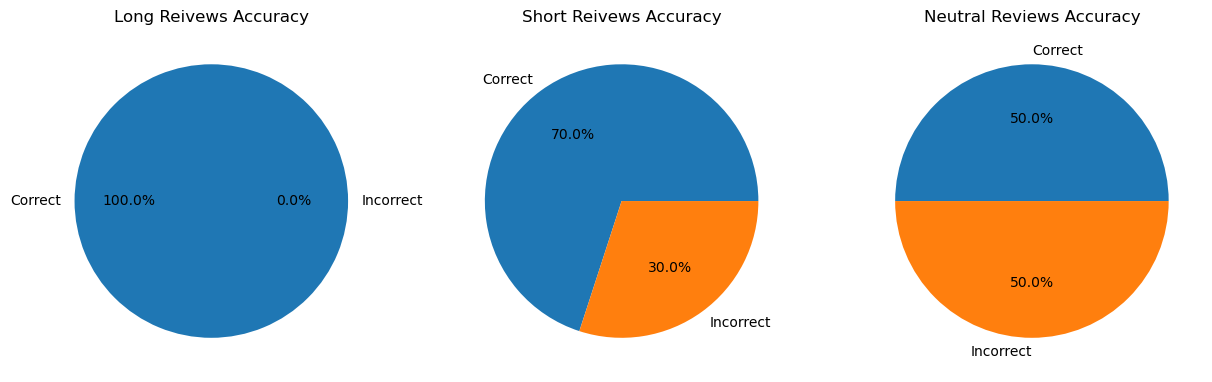

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

predictions = [normal_sentiment_prediction, short_sentiment_predictions, neutral_sentiment_predictions]
titles = ["Long Reivews Accuracy", "Short Reivews Accuracy", "Neutral Reviews Accuracy"]
for i in range(3):
    correct = sum(correct == predicted for (correct, predicted) in predictions[i])
    incorrect = len(predictions[i]) - correct
    
    axes[i].pie([correct, incorrect], labels=['Correct', 'Incorrect'], autopct='%1.1f%%')
    axes[i].set_title(titles[i])

plt.show()